In [394]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.linear_model import LinearRegression
from patsy import cr
from patsy import bs
from patsy import dmatrix

# utf-8 error, need to check encoding
with open('data\\SeoulBikeData.csv') as f:
    print(f)
    
df = pd.read_csv('C:\\Users\\Ping\\Desktop\\Project\\Bike_share\\data\\SeoulBikeData.csv', encoding = 'cp1252', dayfirst=True)

<_io.TextIOWrapper name='data\\SeoulBikeData.csv' mode='r' encoding='cp1252'>


In [396]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [397]:
df.describe(include='all')
# Count is uniform throughout, assume no NaN's

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760,8760,8760
unique,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,2
top,01/12/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,No Holiday,Yes
freq,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2208,8328,8465
mean,NaN,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,NaN,NaN,NaN
std,NaN,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,NaN,NaN,NaN
min,NaN,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,NaN,NaN,NaN
50%,NaN,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,NaN,NaN,NaN
75%,NaN,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,NaN,NaN,NaN


In [398]:
df.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [399]:
print(df['Hour'][df['Functioning Day']=='No'].count())
print(df['Date'][df['Functioning Day']=='No'].nunique())
print(df['Date'][df['Functioning Day']=='No'].unique())
df[df['Functioning Day']=='No']
# 295 hours over 13 days when it wasn't functioning and there were no bikes rented
# These should be treated as NaN values 
# We can use seasonal (hourly) adjustment, or since the days are scattered, we could fill with adjacent days
# However, the weather on adjacent days may be quite different
# Try Multiple Imputation by Chained Equations - but really, only one column (Rented Bike Count) is invalid

# Assumption of Missing at Random is reasonable

# I assume imputing via regression should not affect output of regression - we can test this

# impute.SimpleImputer - univariate imputation, but this may mess up confidence since it is not iterated

295
13
['11/04/2018' '10/05/2018' '18/09/2018' '19/09/2018' '28/09/2018'
 '30/09/2018' '02/10/2018' '04/10/2018' '06/10/2018' '09/10/2018'
 '03/11/2018' '06/11/2018' '09/11/2018']


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
3144,11/04/2018,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No Holiday,No
3145,11/04/2018,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No Holiday,No
3146,11/04/2018,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No Holiday,No
3147,11/04/2018,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No Holiday,No
3148,11/04/2018,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No Holiday,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8251,09/11/2018,0,19,11.9,71,2.7,589,6.7,0.0,0.0,0.0,Autumn,No Holiday,No
8252,09/11/2018,0,20,11.9,72,2.5,526,7.0,0.0,0.0,0.0,Autumn,No Holiday,No
8253,09/11/2018,0,21,11.4,74,1.9,498,6.9,0.0,0.0,0.0,Autumn,No Holiday,No
8254,09/11/2018,0,22,11.2,75,1.7,478,6.9,0.0,0.0,0.0,Autumn,No Holiday,No


In [400]:
# Exploratory
# Daily pattern - expect few rentals at night?
df_daily = df[['Rented Bike Count','Hour']].groupby(['Hour']).mean()

<AxesSubplot:xlabel='Hour'>

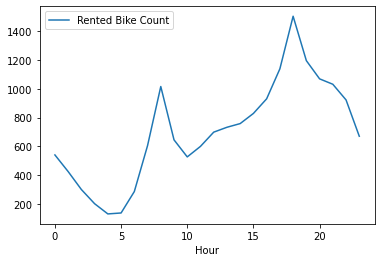

In [401]:
df_daily.plot()
# Shows nightly lull and two rush hour peaks - PM one larger, surprising that it's not symmetric

Friday
Saturday


C:\Users\Ping\anaconda3\lib\site-packages\matplotlib\axes\_base.py:504: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


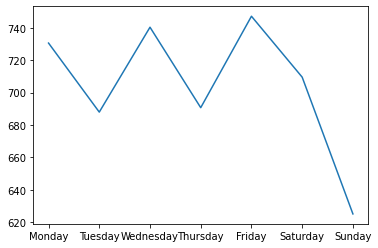

In [402]:
# Day of the week - be careful it's European dates DD-MM-YYYY

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

#df['date/time'] = pd.to_datetime(df['date/time'], format = '%d/%m/%Y %H:%M:%S')

df['Day of Week'] = df['Date'].dt.day_name()

print(df['Day of Week'].loc[0])
print(df['Day of Week'].loc[24])

df_weekly = df[['Day of Week','Rented Bike Count']].groupby(['Day of Week']).mean()

cat = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
df_weekly.index = pd.Categorical(df_weekly.index, categories=cat, ordered=True)
df_weekly = df_weekly.sort_index()

fig, axes = plt.subplots()
axes.plot(df_weekly['Rented Bike Count'])

(0.0, 1800.0)

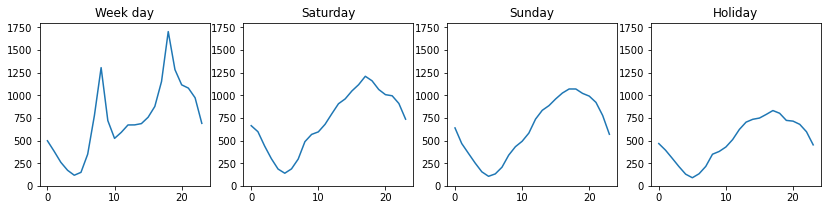

In [403]:
df_Sun = (
    df[['Hour','Rented Bike Count']]
    [df['Day of Week'] =='Sunday']
    .groupby('Hour')
    .agg(['mean',
          'sem'])
)

df_Sat = (
    df[['Hour','Rented Bike Count']]
    [df['Day of Week'] =='Saturday']
    .groupby('Hour')
    .agg(['mean',
         'sem'])
)

df_weekday = (
    df[['Hour','Rented Bike Count']]
    [(df['Day of Week']!='Saturday') & 
     (df['Day of Week']!='Sunday') &
     (df['Holiday']=='No Holiday')]
    .groupby('Hour')
    .agg(['mean',
          'sem'])
)

df_holiday = (
    df[['Hour','Rented Bike Count']]
    [(df['Holiday']=='Holiday')]
    .groupby('Hour')
    .agg(['mean',
          'sem'])
)

fig, axes = plt.subplots(1,4,figsize=(14,3))
axes[0].plot(df_weekday['Rented Bike Count']['mean'])
axes[0].set_title('Week day')
axes[0].set_ylim([0, 1800])
axes[1].plot(df_Sat['Rented Bike Count']['mean'])
axes[1].set_title('Saturday')
axes[1].set_ylim([0, 1800])
axes[2].plot(df_Sun['Rented Bike Count']['mean'])
axes[2].set_title('Sunday')
axes[2].set_ylim([0, 1800])
axes[3].plot(df_holiday['Rented Bike Count']['mean'])
axes[3].set_title('Holiday')
axes[3].set_ylim([0, 1800])

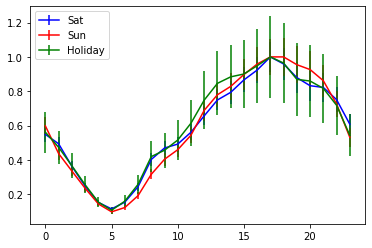

In [404]:
fig, axes = plt.subplots()

norm_Sat = np.max(df_Sat['Rented Bike Count']['mean'].values)
axes.errorbar(df_Sat['Rented Bike Count']['mean'].index,
            df_Sat['Rented Bike Count']['mean'].values/norm_Sat, 
            df_Sat['Rented Bike Count']['sem'].values/norm_Sat,  
            c = 'b')

norm_Sun = np.max(df_Sun['Rented Bike Count']['mean'].values)
axes.errorbar(df_Sun.index, 
            df_Sun['Rented Bike Count']['mean'].values/norm_Sun, 
            df_Sun['Rented Bike Count']['sem'].values/norm_Sun,  
            c ='r')

norm_holiday = np.max(df_holiday['Rented Bike Count']['mean'].values)
axes.errorbar(df_holiday.index, 
            df_holiday['Rented Bike Count']['mean'].values/norm_holiday, 
            df_holiday['Rented Bike Count']['sem'].values/norm_holiday,  
            c ='g')

axes.legend(['Sat','Sun','Holiday'])

plt.show()

# Since std(aX) = abs(a)*std(X), standard error should scale linearly with normalization

# Essentially the same - holiday is a small n set and may vary a lot by season, etc.

# Combine all non-work days for hourly

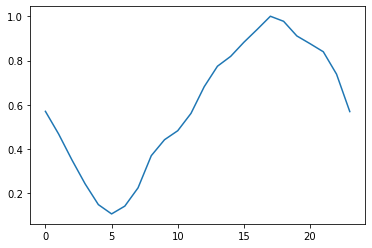

In [405]:
df_nonwork = (
    df[['Hour','Rented Bike Count']]
    [(df['Day of Week']=='Sunday') | 
       (df['Day of Week']=='Saturday') |
       (df['Holiday']=='Holiday')]
    .groupby('Hour')
    .mean()
)

df_nonwork['Rented Bike Re Max'] = df_nonwork.values / max(df_nonwork.values)
plt.plot(df_nonwork['Rented Bike Re Max'])

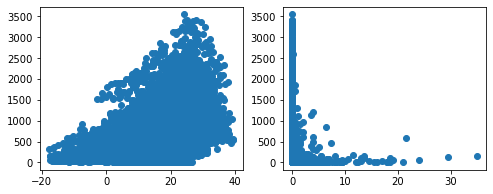

In [406]:
# Look at some expected correlations after deseasonalizing - e.g., rain, temperature

fig, axes = plt.subplots(1,2,figsize=(8,3))
axes[0].scatter(df['Temperature(°C)'], df['Rented Bike Count'])

axes[1].scatter(df['Rainfall(mm)'], df['Rented Bike Count'])

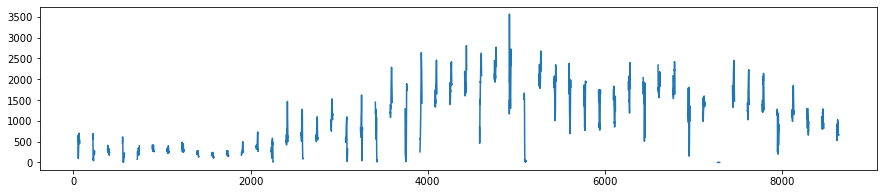

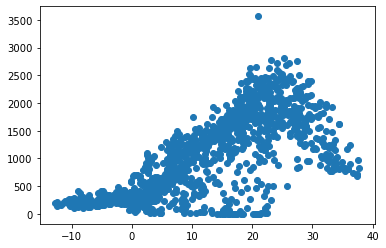

In [407]:
# Want to look at these after removing daily trend 
# Keep workdays and non-workdays separate, ignore season for now, as temperature is kind of a proxy already

#df['de-daily'][df['Day of Week'] =='Sunday'] = (


for i in range(0,len(df)):
    if (df['Day of Week'][i] =='Sunday'):
        df.loc[i,'de_daily_nw'] = (
            df.loc[i,'Rented Bike Count']
            /df_nonwork.loc[df['Hour'][i],'Rented Bike Re Max']  
        ) # Multiplicative removal of nonwork daily average

# Built in produces weird results for intervening missing points on the other days
#decomp = seasonal_decompose(temp['Rented Bike Count'], model='additive', period=24)
#seas_Sun = decomp.seasonal    

fig, axes = plt.subplots(1,1, figsize=(15,3))
axes.plot(df['de_daily_nw'])
#ax.set_xlim((50,75))

fig2 = plt.figure()
plt.scatter(df['Temperature(°C)'][df['Rainfall(mm)']<3], df['de_daily_nw'][df['Rainfall(mm)']<3])
# There's some factor (other than rain) causing a cluster of non-rentals even in moderate temperatures 
# There is a non-surprising non-linear relationship with temperature - people don't want to ride when it is too hot or too cold
# Also looks like it's occurring on particular days

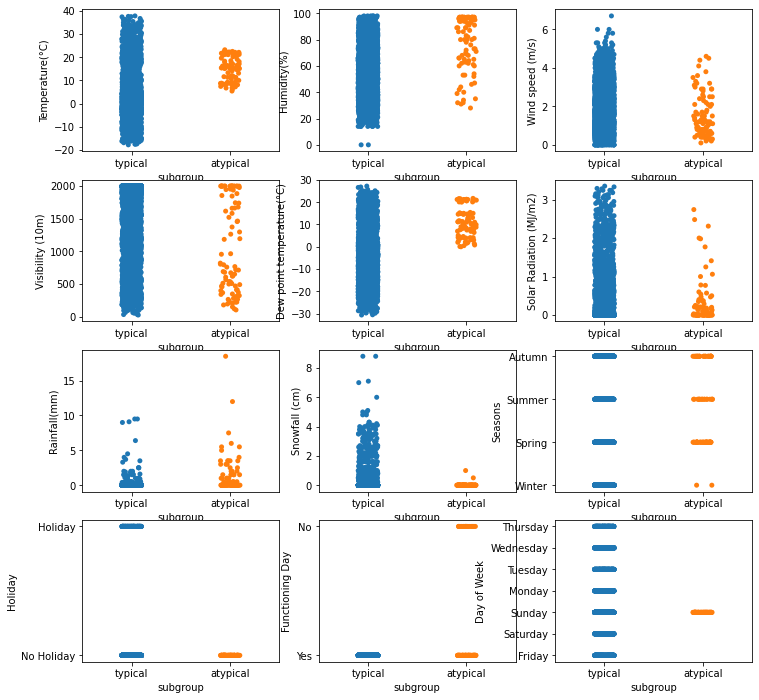

In [408]:
df.loc[(df['Temperature(°C)']>5) & (df['de_daily_nw']<300), 'subgroup'] = 'atypical'
df.loc[(df['Temperature(°C)']<5) | (df['de_daily_nw']>300), 'subgroup'] = 'typical'

fig = plt.figure(figsize=(12,12))

for i in range(3,df.shape[1]-2):
    #plt.sca(axes[(i-3)%  ])
    ax = fig.add_subplot(4, 3, i-2)
    plt.sca(ax)
    sns.stripplot(data = df,
              x = 'subgroup',
#              y = 'Temperature(°C)',
              y = df.columns[i],
              )


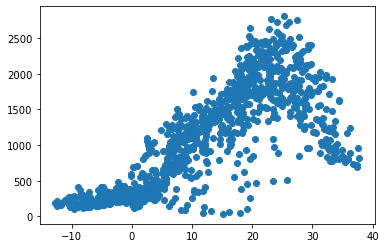

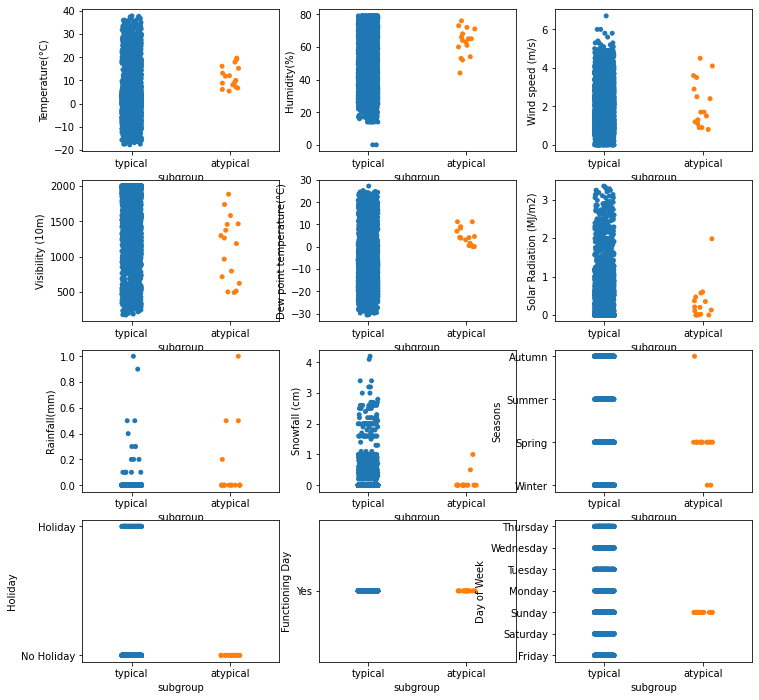

In [409]:
fig4 = plt.figure()
inds = (
    (df['Rainfall(mm)']<3) & 
    (df['Functioning Day']=='Yes') & 
    (df['Humidity(%)']<80)  
)
plt.scatter(df['Temperature(°C)'][inds], df['de_daily_nw'][inds])

df.loc[(df['Temperature(°C)']>5) & (df['de_daily_nw']<300), 'subgroup'] = 'atypical'
df.loc[(df['Temperature(°C)']<5) | (df['de_daily_nw']>300), 'subgroup'] = 'typical'
df.loc[~inds,'subgroup'] = None

fig = plt.figure(figsize=(12,12))

for i in range(3,df.shape[1]-2):
    ax = fig.add_subplot(4, 3, i-2)
    plt.sca(ax)
    sns.stripplot(data = df,
              x = 'subgroup',
              y = df.columns[i],
              )


In [372]:
df[df['subgroup']=='atypical']
# Warm winter day with snowfall
# Very overcast day based on solar radiation
# April 15th 2018 Seoul was enshrouded in fine dust and sand from China? https://www.upi.com/Top_News/World-News/2018/04/15/Fine-dust-levels-soar-in-South-Korea/5581523776231/
# But not reflected in visibility?
# Certainly pollution levels (and in a place like California, fires etc.) should be included in such models

# More consistently, all of these are Sundays - but only a subset of Sundays and a few hours. Puzzling.

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Day of Week,de_daily_nw,subgroup
231,2017-12-10,180,15,6.7,63,4.5,715,0.1,0.35,0.0,1.0,Winter,No Holiday,Yes,Sunday,203.938750,atypical
232,2017-12-10,214,16,5.4,71,3.5,622,0.5,0.20,0.0,0.5,Winter,No Holiday,Yes,Sunday,227.585346,atypical
2587,2018-03-18,237,19,10.0,53,1.7,796,0.8,0.01,0.0,0.0,Spring,No Holiday,Yes,Sunday,260.141394,atypical
2588,2018-03-18,146,20,9.2,66,1.1,513,3.1,0.00,0.0,0.0,Spring,No Holiday,Yes,Sunday,166.663493,atypical
2589,2018-03-18,71,21,8.8,72,0.9,501,4.0,0.00,0.0,0.0,Spring,No Holiday,Yes,Sunday,84.562240,atypical
2590,2018-03-18,70,22,8.1,76,0.8,492,4.1,0.00,0.0,0.0,Spring,No Holiday,Yes,Sunday,94.801995,atypical
3088,2018-04-08,137,16,6.1,65,1.5,1465,0.0,0.21,0.0,0.0,Spring,No Holiday,Yes,Sunday,145.697161,atypical
3255,2018-04-15,62,15,13.1,54,4.1,1264,3.9,1.98,0.0,0.0,Spring,No Holiday,Yes,Sunday,70.245569,atypical
3256,2018-04-15,124,16,12.0,61,3.6,1374,4.6,0.57,0.0,0.0,Spring,No Holiday,Yes,Sunday,131.871883,atypical
3257,2018-04-15,42,17,11.8,60,2.9,1457,4.2,0.60,0.0,0.0,Spring,No Holiday,Yes,Sunday,42.000000,atypical


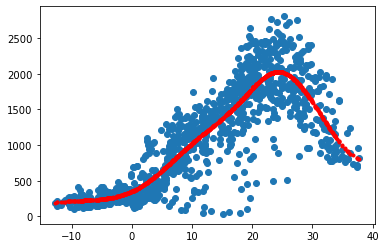

In [427]:
# Assess univariate spline regression using Patsy library, knot locations

fig4 = plt.figure()
#plt.scatter(df['Temperature(°C)'][inds], df['de_daily_nw'][inds])

df2 = df.dropna()
x = df2['Temperature(°C)'].values
y = df2['de_daily_nw'].values

#x_basis = cr(x, df=7)
#x_basis = bs(x, knots=(3,25))
x_basis = bs(x, df=7)
model = LinearRegression().fit(x_basis, y)
y_hat = model.predict(x_basis)

plt.scatter(x, y)
plt.plot(x, y_hat, ls="", marker=".", color="red") # Only this changed
plt.show()


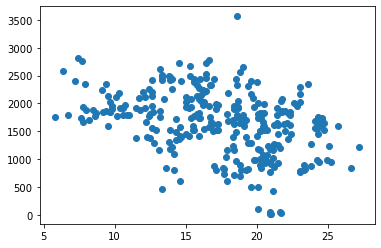

In [434]:
# Effect of dew point, which may be more tightly related to subjective comfort outdoors, vs humidity

fig4 = plt.figure()
inds = (
    (df['Rainfall(mm)']<3) & 
    (df['Functioning Day']=='Yes') &
    (df['Seasons']=='Summer')
)

plt.scatter(df['Dew point temperature(°C)'][inds], df['de_daily_nw'][inds])

# Still, South Korea's climate seems pretty far from the oppressive regime
# Hence, a relatively minor factor? perhaps linear within season?


In [ ]:
# Rain

In [ ]:
# Visibility